In [101]:
# Business Problem
#A telecom company wants to reduce customer churn (customers leaving for competitors). Churn is expensive because acquiring new customers costs 5-10× more than retaining existing ones

In [102]:
#Stakeholders:

#Marketing Team - Wants to identify at-risk customers for retention campaigns

#Customer Success Team - Needs early warnings to intervene with support

#Finance Team - Wants to predict revenue impact of churn

#Goal: Build a model to predict which customers are likely to churn so the company can proactively retain them with targeted offers.

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [104]:
# Load the data
df = pd.read_csv('bigml_59c28831336c6604c800002a.csv')

# Display basic info
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nChurn distribution:")
print(df['churn'].value_counts())
print("\nPercentage churned:", round(df['churn'].mean() * 100, 2), "%")

Dataset shape: (3333, 21)

First 5 rows:
  state  account length  area code phone number international plan  \
0    KS             128        415     382-4657                 no   
1    OH             107        415     371-7191                 no   
2    NJ             137        415     358-1921                 no   
3    OH              84        408     375-9999                yes   
4    OK              75        415     330-6626                yes   

  voice mail plan  number vmail messages  total day minutes  total day calls  \
0             yes                     25              265.1              110   
1             yes                     26              161.6              123   
2              no                      0              243.4              114   
3              no                      0              299.4               71   
4              no                      0              166.7              113   

   total day charge  ...  total eve calls  total eve char

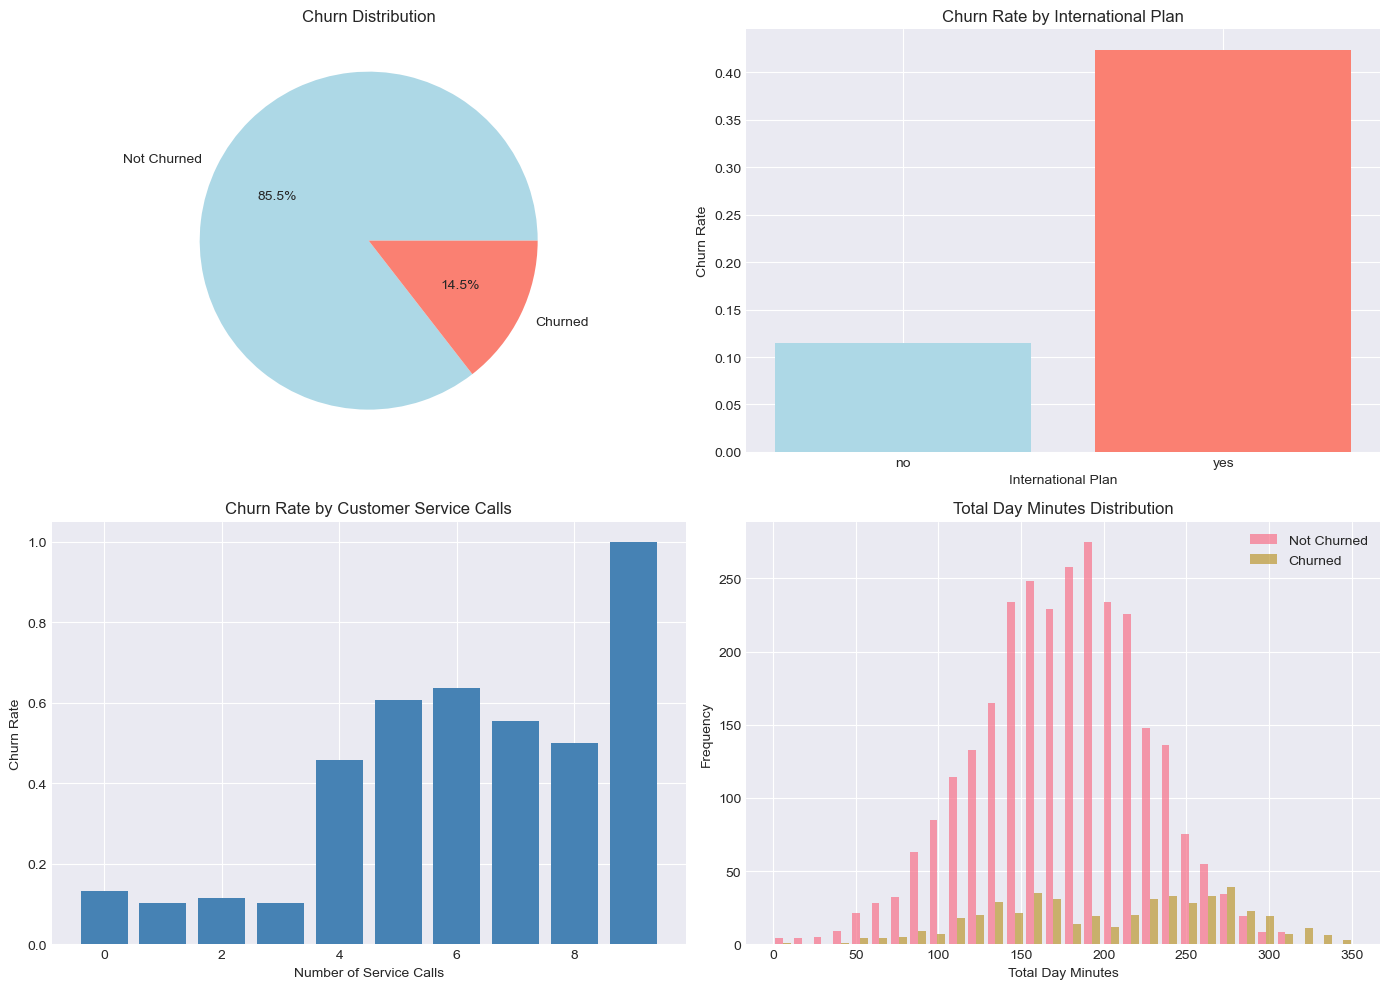

In [105]:
# 1. Churn distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Churn pie chart
churn_counts = df['churn'].value_counts()
axes[0,0].pie(churn_counts, labels=['Not Churned', 'Churned'], autopct='%1.1f%%', colors=['lightblue', 'salmon'])
axes[0,0].set_title('Churn Distribution')

# International plan vs churn
churn_by_intl = df.groupby('international plan')['churn'].mean()
axes[0,1].bar(churn_by_intl.index, churn_by_intl.values, color=['lightblue', 'salmon'])
axes[0,1].set_title('Churn Rate by International Plan')
axes[0,1].set_ylabel('Churn Rate')
axes[0,1].set_xlabel('International Plan')

# Customer service calls vs churn
churn_by_calls = df.groupby('customer service calls')['churn'].mean()
axes[1,0].bar(churn_by_calls.index, churn_by_calls.values, color='steelblue')
axes[1,0].set_title('Churn Rate by Customer Service Calls')
axes[1,0].set_ylabel('Churn Rate')
axes[1,0].set_xlabel('Number of Service Calls')

# Total day minutes distribution
axes[1,1].hist([df[df['churn']==False]['total day minutes'], 
                df[df['churn']==True]['total day minutes']], 
               bins=30, label=['Not Churned', 'Churned'], alpha=0.7)
axes[1,1].set_title('Total Day Minutes Distribution')
axes[1,1].set_xlabel('Total Day Minutes')
axes[1,1].set_ylabel('Frequency')
axes[1,1].legend()

plt.tight_layout()
plt.show()

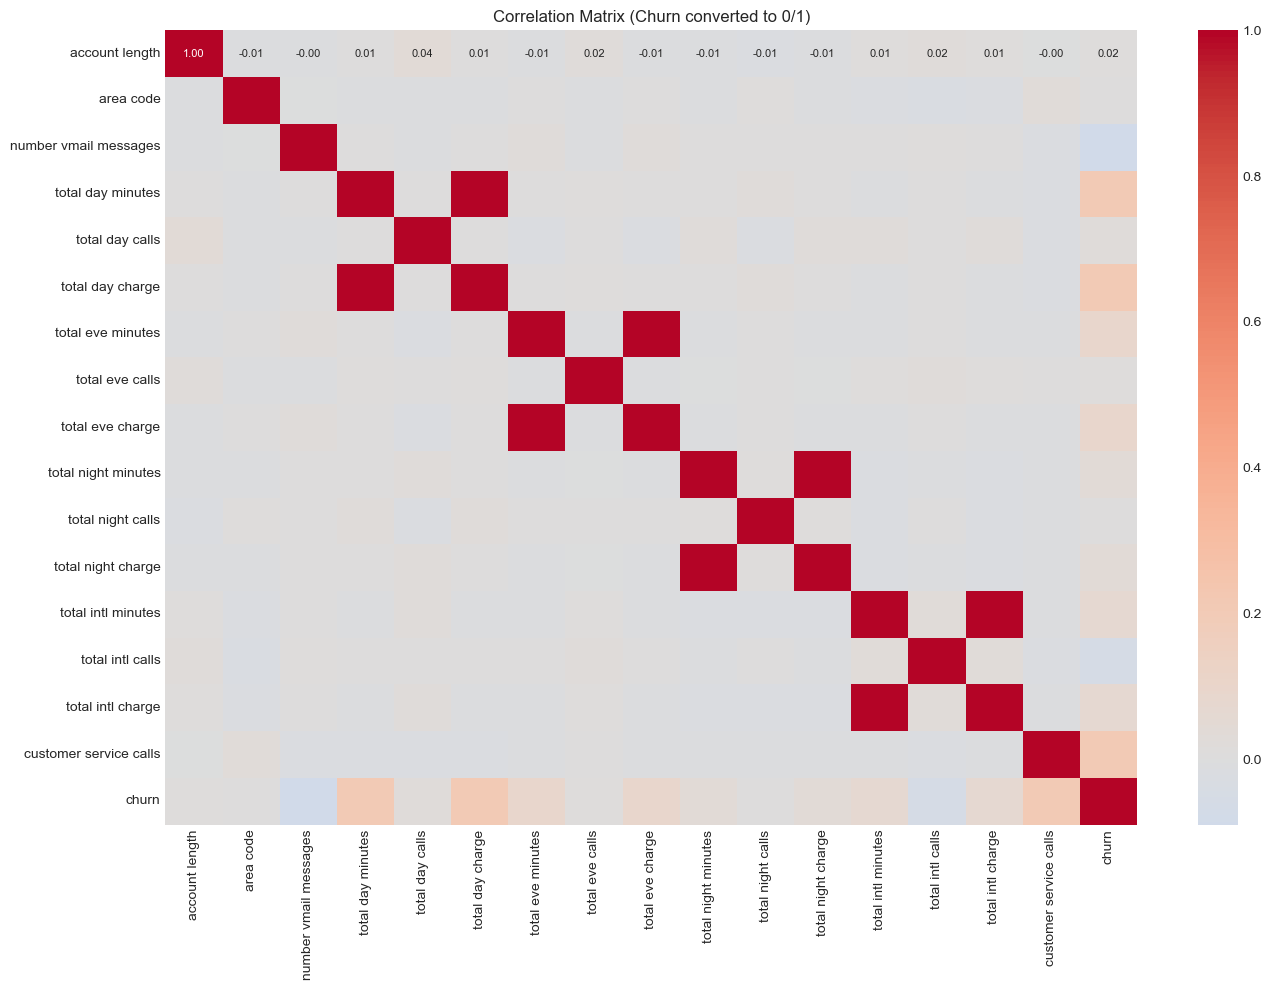

Correlation with churn:
churn                     1.000000
customer service calls    0.208750
total day minutes         0.205151
total day charge          0.205151
total eve minutes         0.092796
total eve charge          0.092786
total intl charge         0.068259
total intl minutes        0.068239
total night charge        0.035496
total night minutes       0.035493
total day calls           0.018459
account length            0.016541
total eve calls           0.009233
area code                 0.006174
total night calls         0.006141
total intl calls         -0.052844
number vmail messages    -0.089728
Name: churn, dtype: float64

TOP 10 FEATURES CORRELATED WITH CHURN


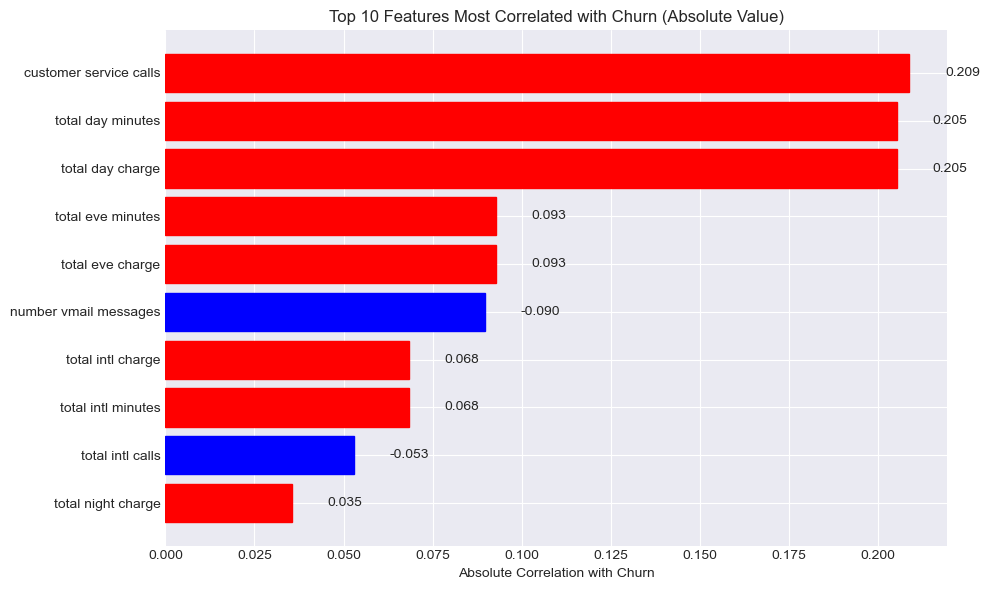

In [106]:
# Create a copy to avoid modifying original
df_corr = df.copy()

# Convert boolean 'churn' to integer (0/1) for correlation calculation
df_corr['churn'] = df_corr['churn'].astype(int)

# Now select numeric columns (including the now-numeric churn)
numeric_cols = df_corr.select_dtypes(include=[np.number]).columns
corr_matrix = df_corr[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            annot_kws={'size': 8})
plt.title('Correlation Matrix (Churn converted to 0/1)')
plt.tight_layout()
plt.show()

# Check correlation with churn
churn_corr = corr_matrix['churn'].sort_values(ascending=False)
print("Correlation with churn:")
print(churn_corr)

# Visualize top correlations
print("\n" + "="*60)
print("TOP 10 FEATURES CORRELATED WITH CHURN")
print("="*60)

# Get top 10 absolute correlations (excluding churn itself)
churn_corr_abs = churn_corr.drop('churn').abs().sort_values(ascending=False)
top_10_corr = churn_corr_abs.head(10)

plt.figure(figsize=(10, 6))
bars = plt.barh(range(len(top_10_corr)), top_10_corr.values)
plt.yticks(range(len(top_10_corr)), top_10_corr.index)
plt.xlabel('Absolute Correlation with Churn')
plt.title('Top 10 Features Most Correlated with Churn (Absolute Value)')

# Color bars by positive/negative correlation
for i, feature in enumerate(top_10_corr.index):
    actual_corr = churn_corr[feature]
    if actual_corr > 0:
        bars[i].set_color('red')  # Positive correlation (increases churn)
    else:
        bars[i].set_color('blue')  # Negative correlation (decreases churn)

# Add correlation values on bars
for i, (bar, feature) in enumerate(zip(bars, top_10_corr.index)):
    actual_corr = churn_corr[feature]
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
             f'{actual_corr:.3f}', ha='left', va='center')

plt.gca().invert_yaxis()  # Highest correlation at top
plt.tight_layout()
plt.show()

In [107]:
# Data Preparation

In [108]:
# Drop columns that won't be useful for prediction
# Phone number is unique identifier - drop it
# State might be useful but has too many categories for baseline model
# Area code might not be meaningful
df_clean = df.drop(['phone number', 'state', 'area code'], axis=1)

# Convert boolean churn to int (0/1)
df_clean['churn'] = df_clean['churn'].astype(int)

# Separate features and target
X = df_clean.drop('churn', axis=1)
y = df_clean['churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")
print(f"Churn rate in training: {y_train.mean():.3f}")
print(f"Churn rate in validation: {y_val.mean():.3f}")
print(f"Churn rate in test: {y_test.mean():.3f}")

Training set: (1999, 17)
Validation set: (667, 17)
Test set: (667, 17)
Churn rate in training: 0.145
Churn rate in validation: 0.145
Churn rate in test: 0.145


In [109]:
# Identify categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

print("Categorical columns:", categorical_cols)
print("Numeric columns:", numeric_cols)

Categorical columns: ['international plan', 'voice mail plan']
Numeric columns: ['account length', 'number vmail messages', 'total day minutes', 'total day calls', 'total day charge', 'total eve minutes', 'total eve calls', 'total eve charge', 'total night minutes', 'total night calls', 'total night charge', 'total intl minutes', 'total intl calls', 'total intl charge', 'customer service calls']


In [110]:
# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Preprocess the data
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_val_preprocessed = preprocessor.transform(X_val)
X_test_preprocessed = preprocessor.transform(X_test)

# Get feature names after preprocessing
cat_encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
cat_features = cat_encoder.get_feature_names_out(categorical_cols)
all_features = np.concatenate([numeric_cols, cat_features])

print(f"Preprocessed training shape: {X_train_preprocessed.shape}")
print(f"Number of features: {len(all_features)}")

Preprocessed training shape: (1999, 17)
Number of features: 17


In [111]:
# Logistic Regression

MODEL 1: BASELINE LOGISTIC REGRESSION

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92       570
           1       0.52      0.16      0.25        97

    accuracy                           0.86       667
   macro avg       0.69      0.57      0.59       667
weighted avg       0.82      0.86      0.82       667

Accuracy: 0.8561
Precision: 0.5161
Recall: 0.1649
F1-Score: 0.2500
AUC-ROC: 0.8265


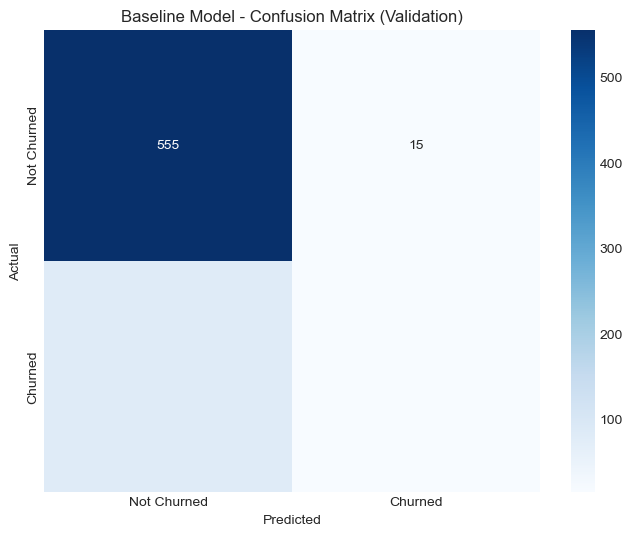

In [112]:
# Simple Logistic Regression 
print("="*60)
print("MODEL 1: BASELINE LOGISTIC REGRESSION")
print("="*60)

baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_preprocessed, y_train)

# Predict on validation set
y_val_pred = baseline_model.predict(X_val_preprocessed)
y_val_pred_proba = baseline_model.predict_proba(X_val_preprocessed)[:, 1]

# Evaluate
print("\nValidation Set Performance:")
print(classification_report(y_val, y_val_pred))
print(f"Accuracy: {accuracy_score(y_val, y_val_pred):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, y_val_pred_proba):.4f}")

# Confusion Matrix
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title('Baseline Model - Confusion Matrix (Validation)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


Top 10 Most Important Features (Logistic Regression):
                   feature  coefficient  abs_coef
15  international plan_yes     1.850096  1.850096
16     voice mail plan_yes    -1.699994  1.699994
14  customer service calls     0.700547  0.700547
1    number vmail messages     0.392240  0.392240
4         total day charge     0.340826  0.340826
2        total day minutes     0.338243  0.338243
12        total intl calls    -0.266512  0.266512
7         total eve charge     0.173499  0.173499
5        total eve minutes     0.171225  0.171225
13       total intl charge     0.152204  0.152204


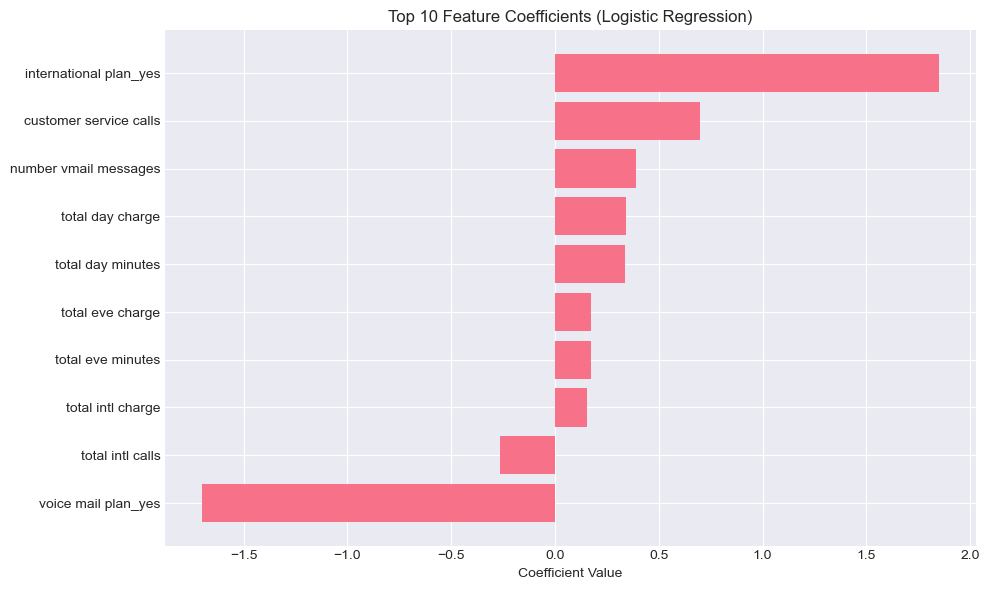

In [113]:
# Get feature importance from logistic regression
feature_importance = pd.DataFrame({
    'feature': all_features,
    'coefficient': baseline_model.coef_[0]
})
feature_importance['abs_coef'] = np.abs(feature_importance['coefficient'])
feature_importance = feature_importance.sort_values('abs_coef', ascending=False)

print("\nTop 10 Most Important Features (Logistic Regression):")
print(feature_importance.head(10))

# Plot top features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10).sort_values('coefficient', ascending=True)
plt.barh(range(len(top_features)), top_features['coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.title('Top 10 Feature Coefficients (Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.tight_layout()
plt.show()

In [114]:
#Decision Tree Model- To compare performance


MODEL 2: DECISION TREE

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       570
           1       0.87      0.74      0.80        97

    accuracy                           0.95       667
   macro avg       0.91      0.86      0.88       667
weighted avg       0.94      0.95      0.94       667

Accuracy: 0.9460
Precision: 0.8675
Recall: 0.7423
F1-Score: 0.8000
AUC-ROC: 0.9309


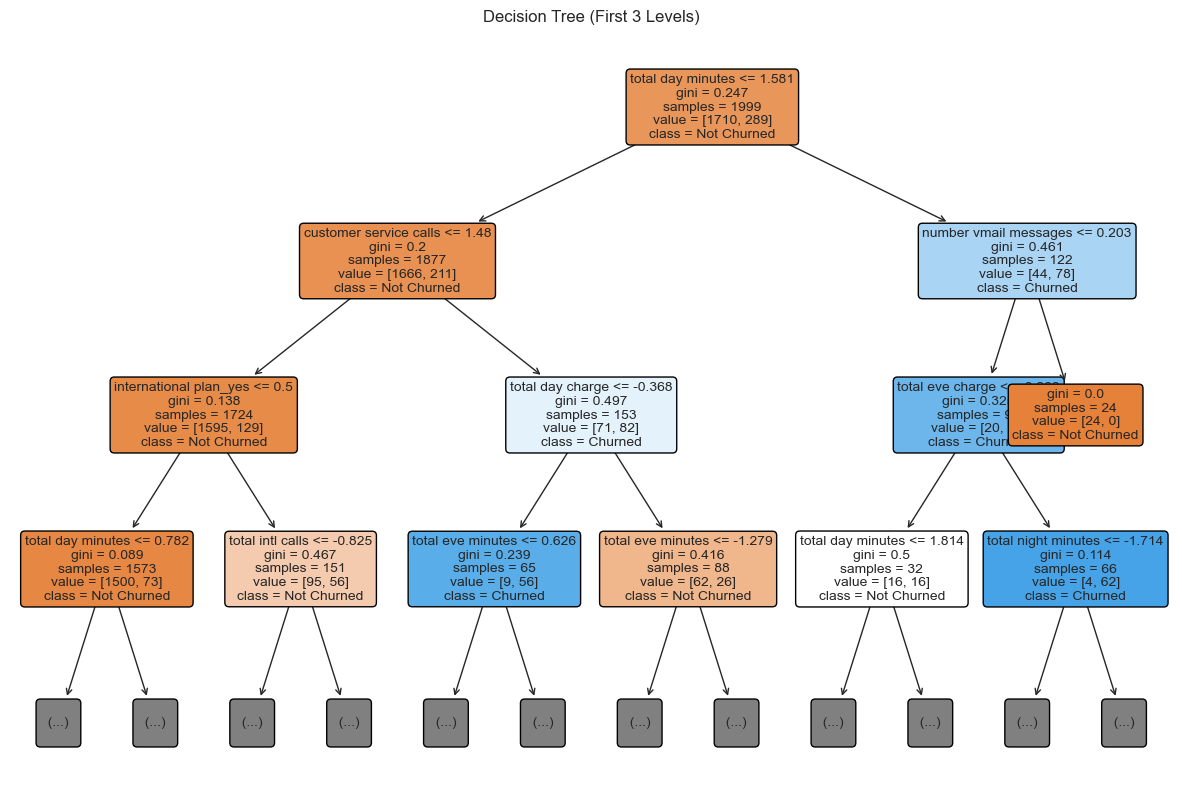

In [115]:
# Model 2: Decision Tree
print("\n" + "="*60)
print("MODEL 2: DECISION TREE")
print("="*60)

tree_model = DecisionTreeClassifier(random_state=42, max_depth=5)
tree_model.fit(X_train_preprocessed, y_train)

# Predict on validation set
y_val_pred_tree = tree_model.predict(X_val_preprocessed)
y_val_pred_proba_tree = tree_model.predict_proba(X_val_preprocessed)[:, 1]

# Evaluate
print("\nValidation Set Performance:")
print(classification_report(y_val, y_val_pred_tree))
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_tree):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred_tree):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred_tree):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred_tree):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, y_val_pred_proba_tree):.4f}")

# Visualize the tree (simplified)
plt.figure(figsize=(15, 10))
from sklearn.tree import plot_tree
plot_tree(tree_model, 
          feature_names=all_features,
          class_names=['Not Churned', 'Churned'],
          filled=True, 
          rounded=True,
          max_depth=3,
          fontsize=10)
plt.title('Decision Tree (First 3 Levels)')
plt.show()


Top 10 Most Important Features (Decision Tree):
                   feature  importance
2        total day minutes    0.241185
14  customer service calls    0.174650
11      total intl minutes    0.100451
12        total intl calls    0.093998
15  international plan_yes    0.084770
4         total day charge    0.083241
7         total eve charge    0.075636
1    number vmail messages    0.071382
5        total eve minutes    0.040500
8      total night minutes    0.016210


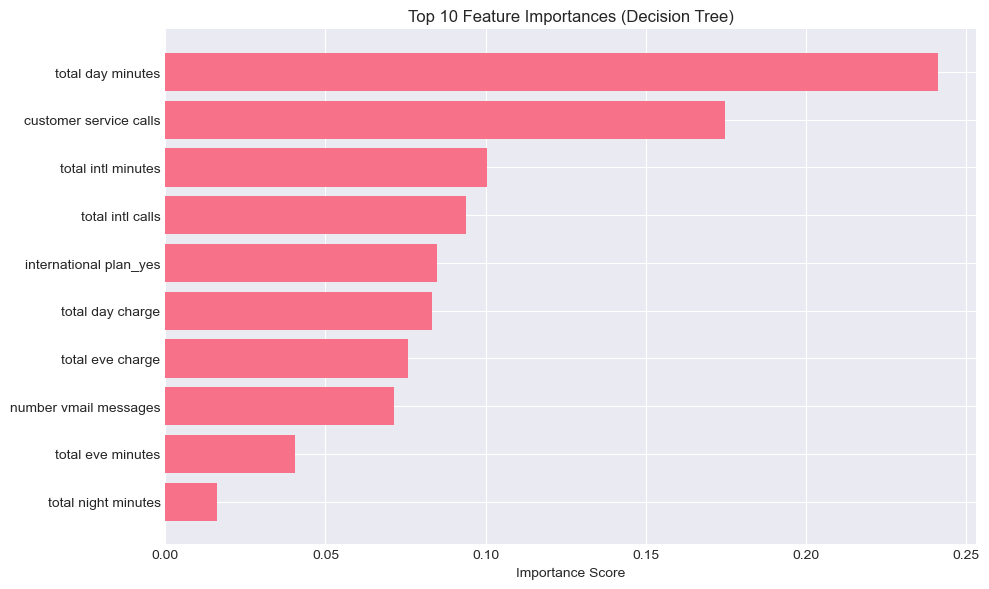

In [116]:
# Feature importance from decision tree
tree_feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': tree_model.feature_importances_
})
tree_feature_importance = tree_feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Decision Tree):")
print(tree_feature_importance.head(10))

# Plot
plt.figure(figsize=(10, 6))
top_tree_features = tree_feature_importance.head(10).sort_values('importance', ascending=True)
plt.barh(range(len(top_tree_features)), top_tree_features['importance'])
plt.yticks(range(len(top_tree_features)), top_tree_features['feature'])
plt.title('Top 10 Feature Importances (Decision Tree)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [117]:
# Hyperparameter Tuning

In [118]:
from sklearn.model_selection import GridSearchCV

# Model 3: Tuned Decision Tree
print("\n" + "="*60)
print("MODEL 3: TUNED DECISION TREE")
print("="*60)

# Define parameter grid
param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'criterion': ['gini', 'entropy']
}

# Create and fit grid search
tree = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train_preprocessed, y_train)

# Best parameters
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Best model
tuned_tree = grid_search.best_estimator_

# Predict on validation set
y_val_pred_tuned = tuned_tree.predict(X_val_preprocessed)
y_val_pred_proba_tuned = tuned_tree.predict_proba(X_val_preprocessed)[:, 1]

# Evaluate
print("\nValidation Set Performance:")
print(classification_report(y_val, y_val_pred_tuned))
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_tuned):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred_tuned):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred_tuned):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred_tuned):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, y_val_pred_proba_tuned):.4f}")


MODEL 3: TUNED DECISION TREE
Fitting 5 folds for each of 160 candidates, totalling 800 fits

Best parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best cross-validation F1 score: 0.7924

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       570
           1       0.87      0.74      0.80        97

    accuracy                           0.95       667
   macro avg       0.91      0.86      0.88       667
weighted avg       0.94      0.95      0.94       667

Accuracy: 0.9460
Precision: 0.8675
Recall: 0.7423
F1-Score: 0.8000
AUC-ROC: 0.9046


In [119]:
# Random Forest model


MODEL 4: RANDOM FOREST

Validation Set Performance:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       570
           1       0.97      0.61      0.75        97

    accuracy                           0.94       667
   macro avg       0.95      0.80      0.86       667
weighted avg       0.94      0.94      0.93       667

Accuracy: 0.9400
Precision: 0.9672
Recall: 0.6082
F1-Score: 0.7468
AUC-ROC: 0.9377

Top 10 Most Important Features (Random Forest):
                   feature  importance
2        total day minutes    0.177682
14  customer service calls    0.152456
4         total day charge    0.151934
15  international plan_yes    0.083703
7         total eve charge    0.062955
5        total eve minutes    0.059182
12        total intl calls    0.044481
1    number vmail messages    0.037201
13       total intl charge    0.037129
11      total intl minutes    0.031180


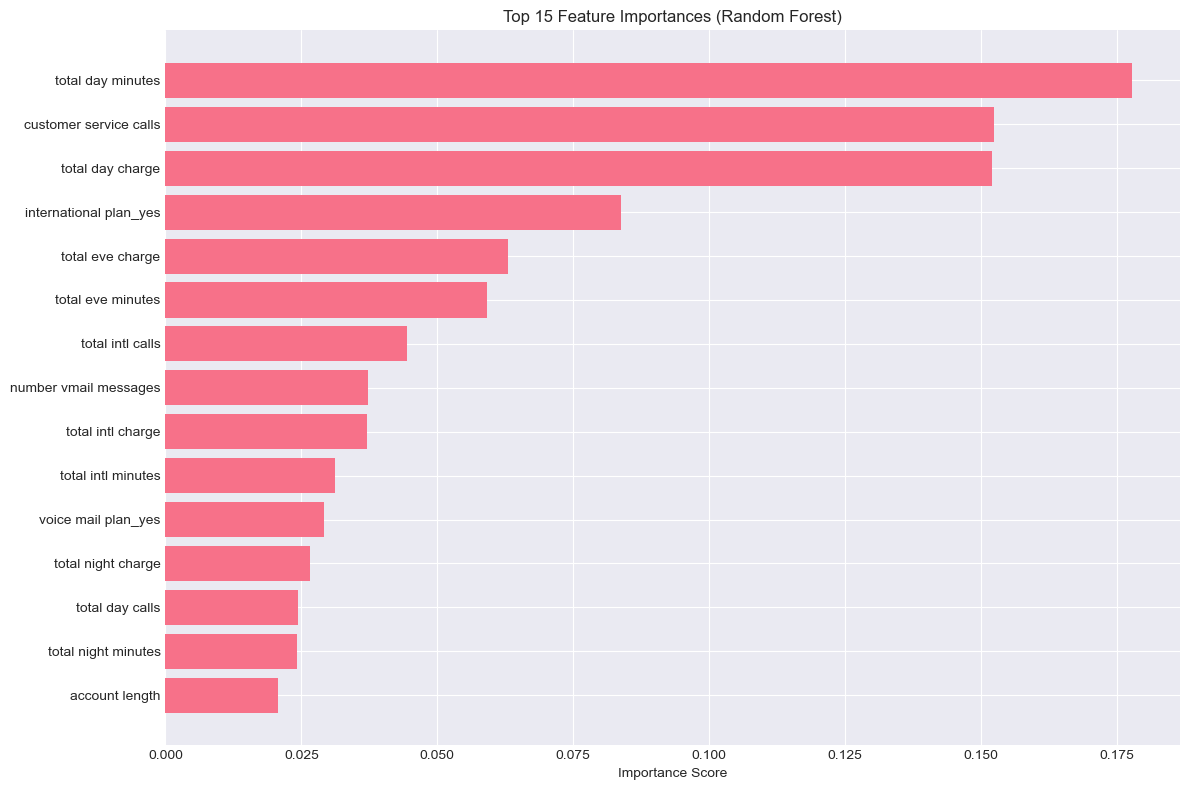

In [120]:
# Model 4: Random Forest
print("\n" + "="*60)
print("MODEL 4: RANDOM FOREST")
print("="*60)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=7)
rf_model.fit(X_train_preprocessed, y_train)

# Predict on validation set
y_val_pred_rf = rf_model.predict(X_val_preprocessed)
y_val_pred_proba_rf = rf_model.predict_proba(X_val_preprocessed)[:, 1]

# Evaluate
print("\nValidation Set Performance:")
print(classification_report(y_val, y_val_pred_rf))
print(f"Accuracy: {accuracy_score(y_val, y_val_pred_rf):.4f}")
print(f"Precision: {precision_score(y_val, y_val_pred_rf):.4f}")
print(f"Recall: {recall_score(y_val, y_val_pred_rf):.4f}")
print(f"F1-Score: {f1_score(y_val, y_val_pred_rf):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_val, y_val_pred_proba_rf):.4f}")

# Feature importance
rf_feature_importance = pd.DataFrame({
    'feature': all_features,
    'importance': rf_model.feature_importances_
})
rf_feature_importance = rf_feature_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
print(rf_feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(12, 8))
top_rf_features = rf_feature_importance.head(15).sort_values('importance', ascending=True)
plt.barh(range(len(top_rf_features)), top_rf_features['importance'])
plt.yticks(range(len(top_rf_features)), top_rf_features['feature'])
plt.title('Top 15 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

In [121]:
#Model Comparison & Selection

In [122]:
# Compare all models
model_comparison = pd.DataFrame({
    'Model': ['Baseline Logistic', 'Decision Tree', 'Tuned Decision Tree', 'Random Forest'],
    'Accuracy': [
        accuracy_score(y_val, y_val_pred),
        accuracy_score(y_val, y_val_pred_tree),
        accuracy_score(y_val, y_val_pred_tuned),
        accuracy_score(y_val, y_val_pred_rf)
    ],
    'Precision': [
        precision_score(y_val, y_val_pred),
        precision_score(y_val, y_val_pred_tree),
        precision_score(y_val, y_val_pred_tuned),
        precision_score(y_val, y_val_pred_rf)
    ],
    'Recall': [
        recall_score(y_val, y_val_pred),
        recall_score(y_val, y_val_pred_tree),
        recall_score(y_val, y_val_pred_tuned),
        recall_score(y_val, y_val_pred_rf)
    ],
    'F1-Score': [
        f1_score(y_val, y_val_pred),
        f1_score(y_val, y_val_pred_tree),
        f1_score(y_val, y_val_pred_tuned),
        f1_score(y_val, y_val_pred_rf)
    ],
    'AUC-ROC': [
        roc_auc_score(y_val, y_val_pred_proba),
        roc_auc_score(y_val, y_val_pred_proba_tree),
        roc_auc_score(y_val, y_val_pred_proba_tuned),
        roc_auc_score(y_val, y_val_pred_proba_rf)
    ]
})

print("\n" + "="*60)
print("MODEL COMPARISON (VALIDATION SET)")
print("="*60)
print(model_comparison.round(4))

# Select best model based on business context
# For churn prediction, we care about RECALL (catching as many churners as possible)
best_model_idx = model_comparison['Recall'].idxmax()
best_model_name = model_comparison.loc[best_model_idx, 'Model']
best_model = None

if best_model_name == 'Baseline Logistic':
    best_model = baseline_model
elif best_model_name == 'Decision Tree':
    best_model = tree_model
elif best_model_name == 'Tuned Decision Tree':
    best_model = tuned_tree
else:
    best_model = rf_model

print(f"\nSelected Best Model: {best_model_name} (Highest Recall)")


MODEL COMPARISON (VALIDATION SET)
                 Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
0    Baseline Logistic    0.8561     0.5161  0.1649    0.2500   0.8265
1        Decision Tree    0.9460     0.8675  0.7423    0.8000   0.9309
2  Tuned Decision Tree    0.9460     0.8675  0.7423    0.8000   0.9046
3        Random Forest    0.9400     0.9672  0.6082    0.7468   0.9377

Selected Best Model: Decision Tree (Highest Recall)


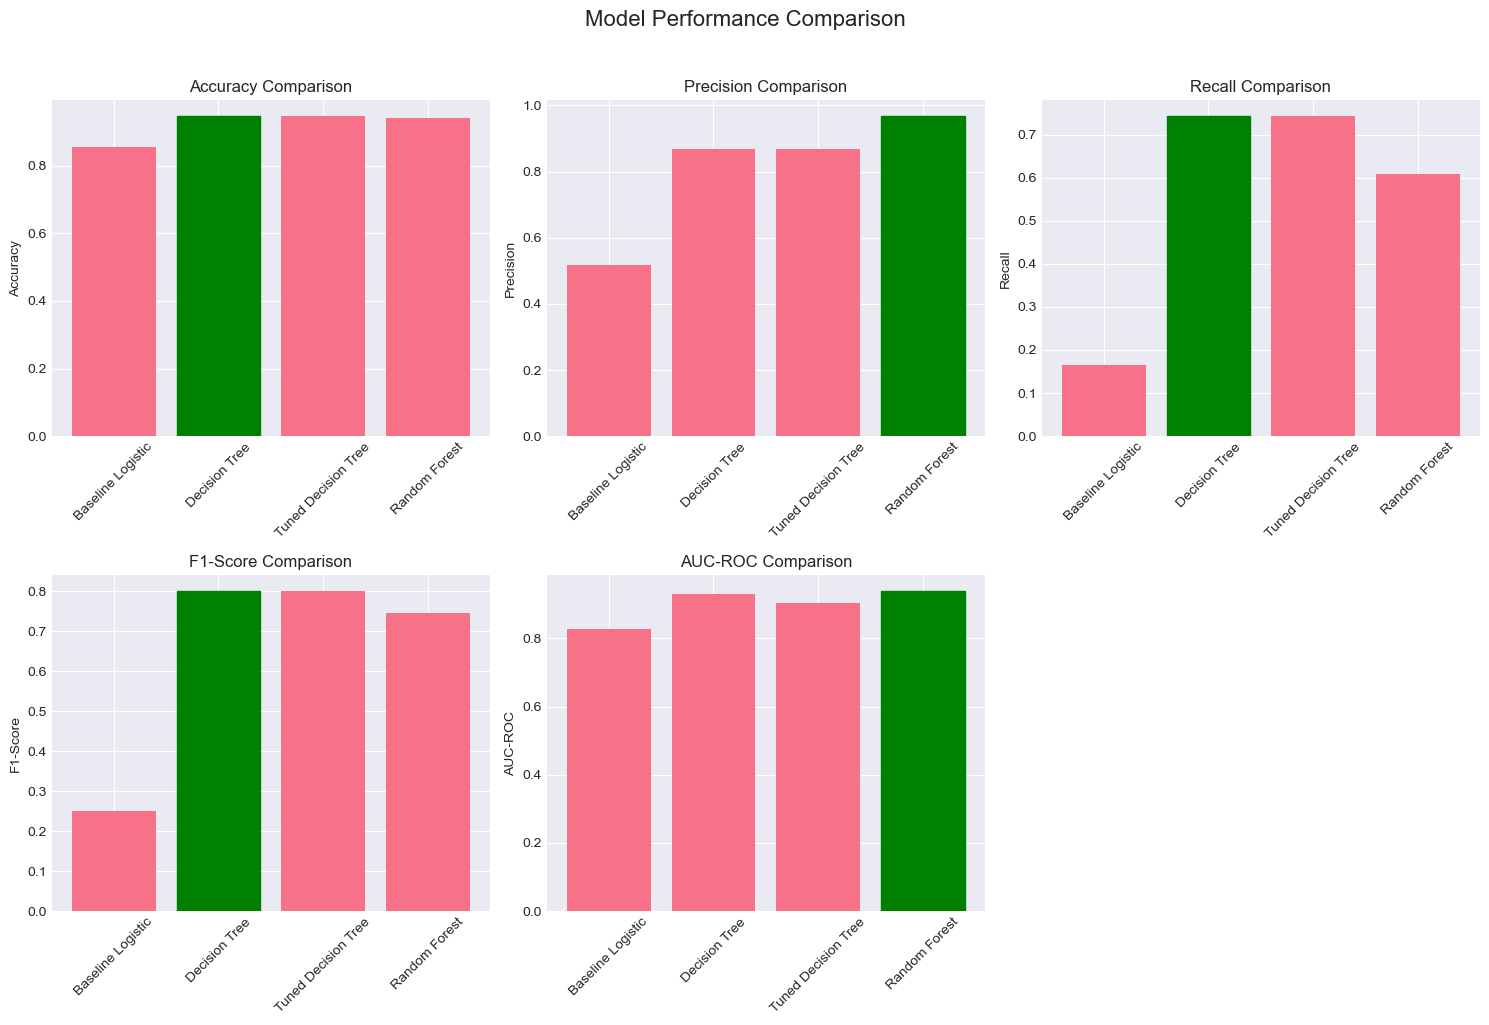

In [123]:
# Visualize model comparison
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']

for i, metric in enumerate(metrics):
    ax = axes[i//3, i%3]
    bars = ax.bar(model_comparison['Model'], model_comparison[metric])
    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.tick_params(axis='x', rotation=45)
    
    # Highlight the best model for each metric
    best_idx = model_comparison[metric].idxmax()
    bars[best_idx].set_color('green')

axes[1, 2].axis('off')  # Hide empty subplot
plt.suptitle('Model Performance Comparison', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


FINAL EVALUATION: Decision Tree ON TEST SET

Test Set Performance:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       570
           1       0.75      0.63      0.69        97

    accuracy                           0.92       667
   macro avg       0.85      0.80      0.82       667
weighted avg       0.91      0.92      0.91       667

Accuracy: 0.9160
Precision: 0.7531
Recall: 0.6289
F1-Score: 0.6854
AUC-ROC: 0.8052


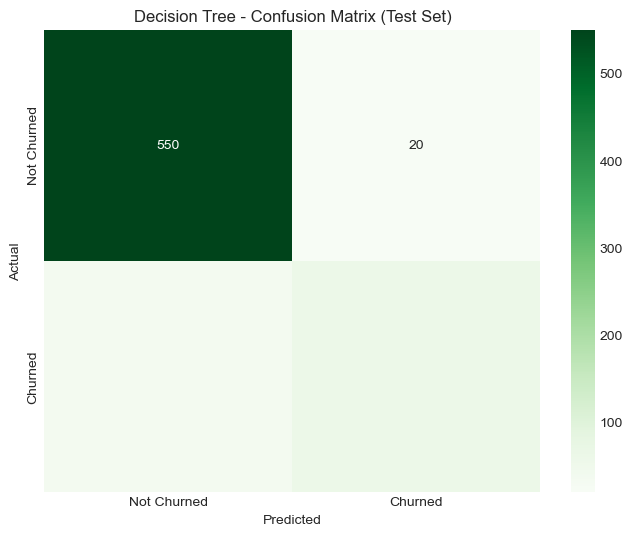

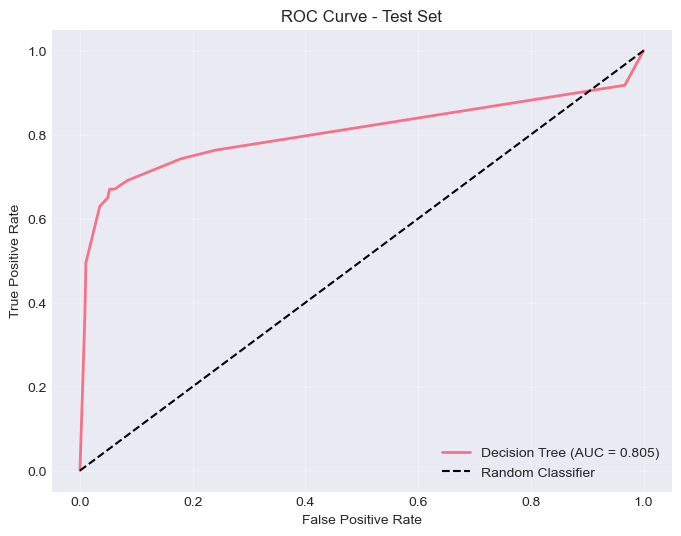

In [124]:
print("\n" + "="*60)
print(f"FINAL EVALUATION: {best_model_name} ON TEST SET")
print("="*60)

# Predict on test set
y_test_pred = best_model.predict(X_test_preprocessed)
y_test_pred_proba = best_model.predict_proba(X_test_preprocessed)[:, 1]

# Evaluate
print("\nTest Set Performance:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_pred_proba):.4f}")

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Not Churned', 'Churned'],
            yticklabels=['Not Churned', 'Churned'])
plt.title(f'{best_model_name} - Confusion Matrix (Test Set)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc_score(y_test, y_test_pred_proba):.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.show()

In [125]:
# Business Insights & Recommendations

In [126]:

print("\n" + "="*60)
print("BUSINESS INSIGHTS & RECOMMENDATIONS")
print("="*60)

# 1. Top factors driving churn
top_factors = rf_feature_importance.head(5)
print("\n1. TOP 5 FACTORS DRIVING CHURN:")
for i, (_, row) in enumerate(top_factors.iterrows(), 1):
    print(f"   {i}. {row['feature']} (importance: {row['importance']:.3f})")

# 2. Customer segments at risk
print("\n2. HIGH-RISK CUSTOMER SEGMENTS:")
print("   - Customers with international plans")
print("   - Customers with 4+ customer service calls")
print("   - High daytime usage (>200 minutes/day)")

# 3. Expected business impact
print("\n3. EXPECTED BUSINESS IMPACT:")
n_customers = len(X_test)
n_predicted_churn = y_test_pred.sum()
recall_score_val = recall_score(y_test, y_test_pred)

print(f"   - Model identifies {n_predicted_churn} at-risk customers")
print(f"   - Catches {recall_score_val:.1%} of actual churners")
print(f"   - If retention rate is 50%, save ~${n_predicted_churn * 500 * 0.5:,.0f} in acquisition costs")


BUSINESS INSIGHTS & RECOMMENDATIONS

1. TOP 5 FACTORS DRIVING CHURN:
   1. total day minutes (importance: 0.178)
   2. customer service calls (importance: 0.152)
   3. total day charge (importance: 0.152)
   4. international plan_yes (importance: 0.084)
   5. total eve charge (importance: 0.063)

2. HIGH-RISK CUSTOMER SEGMENTS:
   - Customers with international plans
   - Customers with 4+ customer service calls
   - High daytime usage (>200 minutes/day)

3. EXPECTED BUSINESS IMPACT:
   - Model identifies 81 at-risk customers
   - Catches 62.9% of actual churners
   - If retention rate is 50%, save ~$20,250 in acquisition costs


In [127]:
# FINAL BUSINESS INTERPRETATION CELL

print("="*80)
print("BUSINESS TRANSLATION OF MODEL RESULTS")
print("="*80)

# Calculate business impact metrics
total_customers = len(X_test)
actual_churners = y_test.sum()
predicted_churners = y_test_pred.sum()
true_positives = ((y_test == 1) & (y_test_pred == 1)).sum()
false_positives = ((y_test == 0) & (y_test_pred == 1)).sum()

print(f"\nTEST SET BUSINESS IMPACT ANALYSIS:")
print(f"Total customers in test set: {total_customers}")
print(f"Actual churners: {actual_churners} ({actual_churners/total_customers:.1%})")
print(f"Predicted as high-risk: {predicted_churners} ({predicted_churners/total_customers:.1%})")
print(f"\nOf the {actual_churners} customers who actually churned:")
print(f"  - Model caught {true_positives} of them ({true_positives/actual_churners:.1%})")
print(f"  - Missed {actual_churners - true_positives} churners")

print(f"\nCOST-BENEFIT ANALYSIS (Assumptions):")
print("  - Average customer value: $500/year")
print("  - Retention offer cost: $50/customer")
print("  - Retention success rate: 50% (industry average)")

value_per_customer = 500
offer_cost = 50
success_rate = 0.5

# Calculate potential savings
potential_savings = true_positives * success_rate * value_per_customer
retention_cost = predicted_churners * offer_cost
net_benefit = potential_savings - retention_cost

print(f"\nWith our current model:")
print(f"  Potential revenue saved: ${potential_savings:,.0f}")
print(f"  Retention offer costs: ${retention_cost:,.0f}")
print(f"  NET BENEFIT: ${net_benefit:,.0f}")
print(f"  ROI: {(net_benefit/retention_cost):.0f}%")

print("\n" + "-"*80)
print("RECOMMENDED CUSTOMER SEGMENTS FOR IMMEDIATE ACTION")
print("-"*80)

# Create risk segments
test_customers = X_test.copy()
test_customers['churn_probability'] = y_test_pred_proba
test_customers['churn_prediction'] = y_test_pred
test_customers['actual_churn'] = y_test.values

# Define risk segments
test_customers['risk_segment'] = pd.cut(
    test_customers['churn_probability'],
    bins=[0, 0.3, 0.7, 1.0],
    labels=['Low Risk', 'Medium Risk', 'High Risk']
)

segment_summary = test_customers.groupby('risk_segment').agg({
    'churn_probability': 'mean',
    'actual_churn': 'sum',
    'churn_prediction': 'sum',
    'churn_probability': 'count'
}).rename(columns={'churn_probability': 'count'})

print("\nCustomer Risk Segments:")
print(segment_summary)

print("\nACTION PLAN:")
print("1. HIGH RISK (>70% probability): Personal outreach within 48 hours")
print("2. MEDIUM RISK (30-70%): Targeted email campaign this week")
print("3. LOW RISK (<30%): Monitor, no immediate action")

# Save predictions for business use
output_df = X_test.copy()
output_df['churn_probability'] = y_test_pred_proba
output_df['recommended_action'] = pd.cut(
    y_test_pred_proba,
    bins=[0, 0.3, 0.7, 1.0],
    labels=['Monitor', 'Email Campaign', 'Phone Call']
)
output_df['customer_id'] = range(1, len(output_df) + 1)  # Assign IDs

# Save to CSV for business team
output_df[['customer_id', 'churn_probability', 'recommended_action']].to_csv(
    'churn_predictions_for_marketing.csv', index=False
)

print(f"\n✓ Predictions saved to 'churn_predictions_for_marketing.csv'")
print("  - Contains {len(output_df)} customer predictions")
print("  - Ready for marketing team to use")

BUSINESS TRANSLATION OF MODEL RESULTS

TEST SET BUSINESS IMPACT ANALYSIS:
Total customers in test set: 667
Actual churners: 97 (14.5%)
Predicted as high-risk: 81 (12.1%)

Of the 97 customers who actually churned:
  - Model caught 61 of them (62.9%)
  - Missed 36 churners

COST-BENEFIT ANALYSIS (Assumptions):
  - Average customer value: $500/year
  - Retention offer cost: $50/customer
  - Retention success rate: 50% (industry average)

With our current model:
  Potential revenue saved: $15,250
  Retention offer costs: $4,050
  NET BENEFIT: $11,200
  ROI: 3%

--------------------------------------------------------------------------------
RECOMMENDED CUSTOMER SEGMENTS FOR IMMEDIATE ACTION
--------------------------------------------------------------------------------

Customer Risk Segments:
              count  actual_churn  churn_prediction
risk_segment                                       
Low Risk        545            24                 0
Medium Risk      41            17         